Zero Noise Extrapolation (ZNE) is a powerful technique in quantum computing aimed at mitigating errors arising from noise and imperfections in quantum hardware. By leveraging measurements from noisy quantum circuits, ZNE algorithms can estimate and correct errors, ultimately enhancing the reliability and accuracy of quantum computations.

In this notebook, I 
- Implement ZNE from scratch
- Compare with the result of reference Mitiq implementation 
- Experiment with ZNE algorithms to optimize its hyperparameters

ℹ️ ℹ️ ℹ️ Readers can modify the `circuit` variable of cell 1 to switch between implemented circuits ℹ️ ℹ️ ℹ️

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

import pennylane as qml
import pennylane.numpy as np
from mitiq.zne.inference import LinearFactory, RichardsonFactory, ExpFactory
from mitiq.zne.scaling import fold_global
import pandas as pd

import util

# ⚠️⚠️⚠️ change this ⚠️⚠️⚠️
circuit = util.circuit_bell_state   # options [util.circuit_bell_state, 
                                     #          util.circuit_hamiltonian]


SIMULATION_MODE = True    # running from local or real hardware
noise_strengths = np.linspace(0.0,0.75,11)
scale_factors = range(4,7)   # at least 4 for exponential extrapolation, due to range of python doesn't include the last element, starting from 3 means the list of scale factors will be range(1,3) = [1,2]
ibmqx_token="xxx"

In [2]:
if circuit == util.circuit_hamiltonian:
    wires = 2
elif circuit == util.circuit_bell_state:
    wires = 2
else:
    raise ValueError("Unsupported circuit")

##  Build a simple noise model with depolarizing noise

In [3]:
if SIMULATION_MODE:
    dev_noise_free = qml.device("default.mixed", wires=wires)
    devs = [qml.transforms.insert(dev_noise_free,
                                  qml.DepolarizingChannel,
                                  noise_strength) 
            for noise_strength in noise_strengths]
else:
    dev = qml.device('qiskit.ibmq', wires=wires, 
                     backend='ibm_kyoto', ibmqx_token=ibmqx_token)
noise_less_dev = qml.device("default.qubit", wires=wires)

## Apply folding method and different extrapolation

We define `results` dataframe to save our experiments. It will have the structure like this

|    |   scale_factor |   noise_strength | extrapolation_type   |    value |
|---:|---------------:|-----------------:|:---------------------|---------:|
|  0 |              1 |              0.1 | linear               | 0.375556 |
|  1 |              1 |              0.1 | polynomial           | 0.375556 |
|  2 |              1 |              0.1 | reference_polynomial | 0.375556 |



In [4]:
dict_list = []
for i_dev, dev in enumerate(devs):   # noise level loop
    noise_lvl = noise_strengths[i_dev]
    device_circuit = qml.QNode(circuit, dev)
    for max_scale_factor in scale_factors:   # max scale factor loop
        # unitary folding
        result_per_noise_level = []
        for scale_factor in range(1, max_scale_factor):   # loop from 1 to current max scale factor
            ops, measurements = util.unitary_fold(device_circuit, scale_factor)
            folded_circuit = util.circuit_from_ops(dev, ops, measurements)
            result_per_noise_level.append(float(folded_circuit))
        # done unitary folding

        # without zne
        dict_list.append(util.create_record('non_zne', noise_lvl, max_scale_factor, device_circuit()))
        
        # extrapolation with the scale factors up to i_scale+1 and current result_per_noise_level        
        dict_list.append(util.create_record('linear', noise_lvl, max_scale_factor,
                      float(util.linear_extrapolation(range(1, max_scale_factor), result_per_noise_level))))
        #dict_list.append(util.create_record('exp', noise_lvl, max_scale_factor,
        #                 float(util.exponential_extrapolation(range(1, max_scale_factor), result_per_noise_level))))
        dict_list.append(util.create_record('polynomial', noise_lvl, max_scale_factor,
                        float(util.polynomial_extrapolation(range(1, max_scale_factor), result_per_noise_level, max_scale_factor-2))))  # scale_factor is in range(1, scale_factor), so its max value is scale_factor-1. Now we -1 once more because of the math in polynomial extrapolation
        
        # reference implementation
        error_mitigated_device_circuit = util.get_reference_extrapolation(device_circuit, max_scale_factor, fold_global, LinearFactory.extrapolate)
        dict_list.append(util.create_record('reference_linear', noise_lvl, max_scale_factor,
                         float(error_mitigated_device_circuit())))
        error_mitigated_device_circuit = util.get_reference_extrapolation(device_circuit, max_scale_factor, fold_global, RichardsonFactory.extrapolate)
        dict_list.append(util.create_record('reference_polynomial', noise_lvl, max_scale_factor,
                         float(error_mitigated_device_circuit())))
        #error_mitigated_device_circuit = util.get_reference_extrapolation(device_circuit, max_scale_factor, fold_global, ExpFactory.extrapolate)
        #dict_list.append(util.create_record('reference_exp', noise_lvl, max_scale_factor,
        #                 float(error_mitigated_device_circuit())))

In [5]:
results = pd.DataFrame(dict_list)

## Research questions

Given a circuit and the noise stregth, it is interesting to see how many fold and which  method to use. To answer that we would plot the `results` dataframe

In [6]:
results['noise_strength'] = results['noise_strength'].astype(float)
results['value'] = results['value'].astype(float)

In [7]:
line_style_plot = {
    'non_zne': ':',
    'reference_linear': '--',
    'reference_exp': '--',
    'reference_polynomial': '--',
    'polynomial': '-',
    'linear': '-',
    'exp': '-'
}

linewidth_plot = {
    'non_zne': 5,    
    'reference_linear': 5,
    'reference_exp': 5,    
    'reference_polynomial': 5,
    'polynomial': 1,
    'linear': 1,
    'exp': 1
}

alpha_plot = {
    'non_zne': 1,
    'reference_linear': 0.2,
    'reference_exp': 0.2,
    'reference_polynomial': 0.2,
    'polynomial': 1,
    'linear': 1,
    'exp': 1    
}

color_plot = {
    'non_zne': 'orange',
    'reference_linear': 'green',
    'reference_exp': 'blue',
    'reference_polynomial': 'red',
    'polynomial': 'red',
    'linear': 'green',
    'exp': 'blue'
}

In [8]:
ideal_result = qml.QNode(circuit, noise_less_dev)()

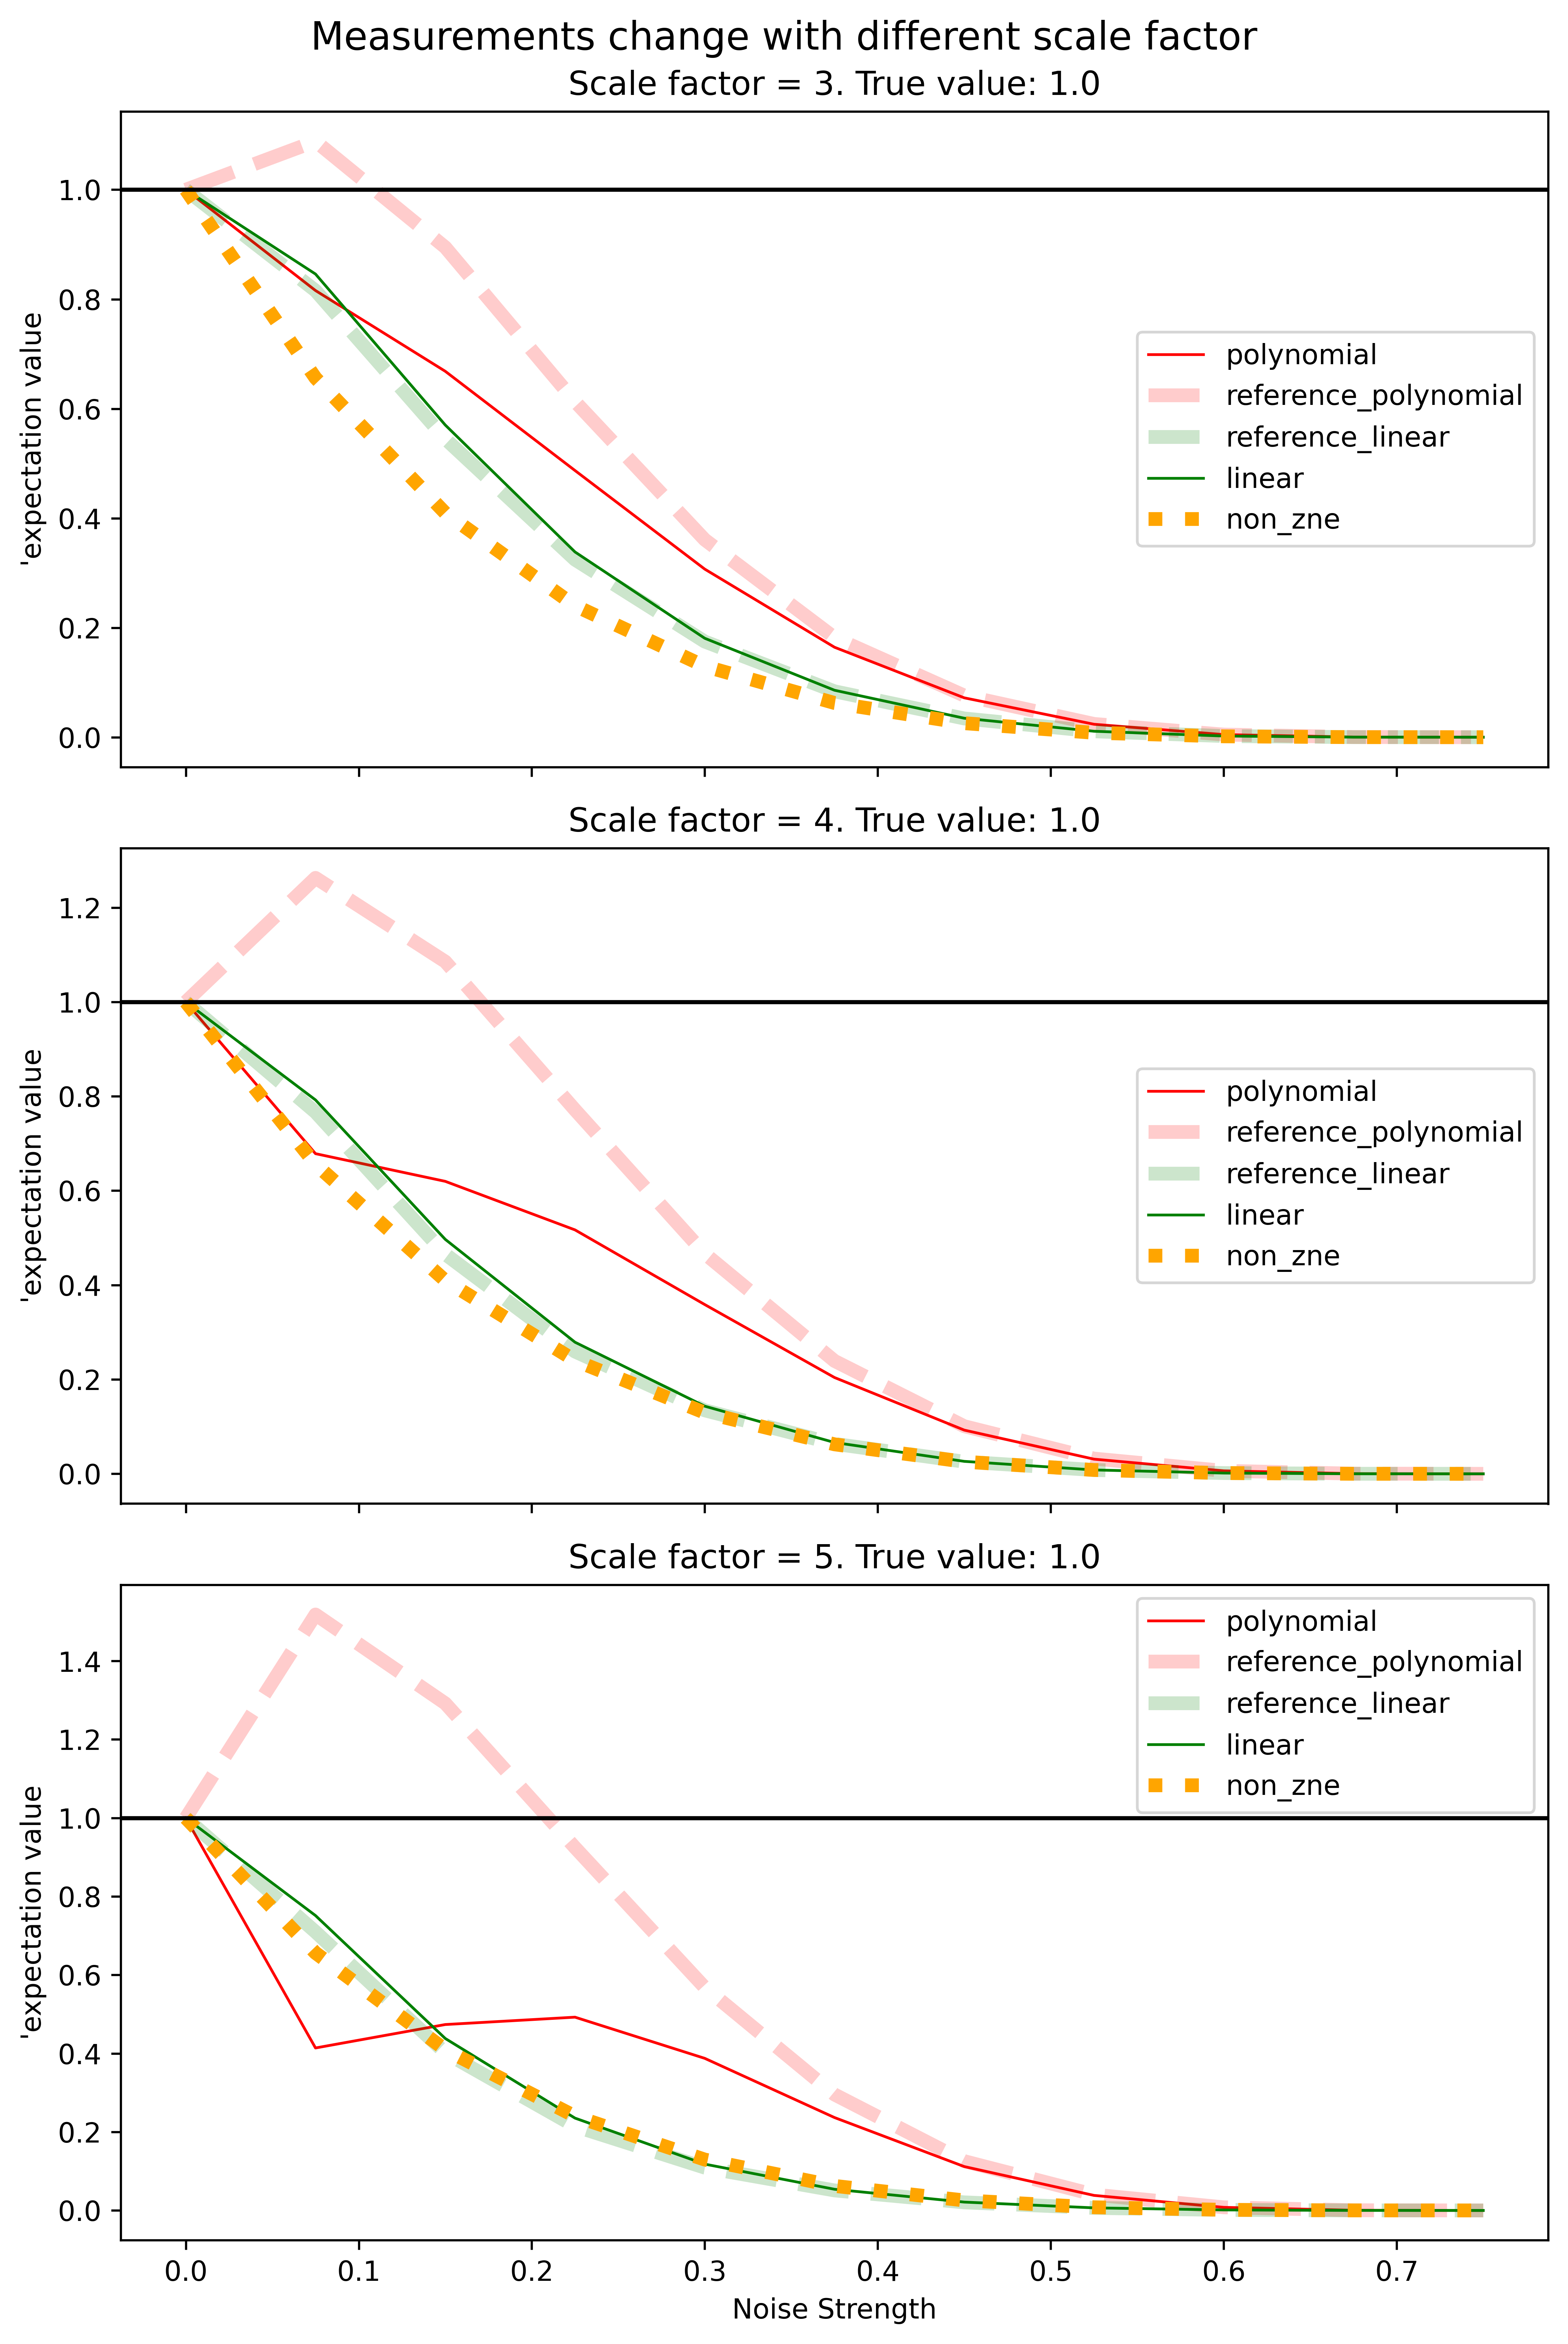

In [9]:
fig, axs = plt.subplots(nrows=len(scale_factors), ncols=1, sharex=True)

# Plot data for each 'extrapolation_type'
for s_factor_index, s_factor in enumerate(scale_factors):
    for extrapolation_type in set(results['extrapolation_type']):
        df = results[(results['extrapolation_type'] == extrapolation_type) & (results["scale_factor"] == s_factor)]
        df.plot(x='noise_strength', y='value', figsize=(8, 12), ax=axs[s_factor_index], 
                label=extrapolation_type, linestyle=line_style_plot[extrapolation_type],
                linewidth=linewidth_plot[extrapolation_type], alpha=alpha_plot[extrapolation_type],
                color=color_plot[extrapolation_type],
               )    
    axs[s_factor_index].axhline(y = ideal_result, color = 'black', linestyle = '-', label="Zero noise result") 
    axs[s_factor_index].set_title(f'Scale factor = {s_factor-1}. True value: {ideal_result}')
    axs[s_factor_index].xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
    axs[s_factor_index].set_ylabel("'expectation value")
    

plt.xlabel("Noise Strength")
fig.suptitle("Measurements change with different scale factor", fontsize=14)
plt.tight_layout()

plt.show()

### Bell circuit (if in cell 1, the user chose `circuit = util.bell_circuit`)

By visually inspecting, the higher the noise, the more fold the polynomial (Richardson) needs to get the expected result. The higher the scale factor, the more it overestimates at the lower noise strength.

The polynomial and linear regression always overlaps on the Miqtiq implementation. However, this is not the case in the next circuit. An explanation is down below

### Hamiltonian circuit (if in cell 1, the user chose `circuit = util.hamilton_circuit`)
Here is an explanation why at small scale factors, the results are different but it is the same in the higher orders. We denote `n_ops` and `n_m` as the number of operators and measurements of a circuits

Original circuit (`n_ops`=3, `n_m`=1. Total = 4)
```
0: ─╭●─────╭●─┤     
1: ─╰X──RZ─╰X─┤  <Z>
```

**For scale factor of 2**

Reference fold (`n_ops`=7, `n_m`=1. Total = 8)
```
0: ─╭●─────╭●─╭●─────────╭●─┤     
1: ─╰X──RZ─╰X─╰X──RZ──RZ─╰X─┤  <Z>
```

My fold (5 Operators, closest to original circuit's `n_ops`*2)
```
0: ─╭●─────╭●─╭●──╭●─┤     
1: ─╰X──RZ─╰X─╰X†─╰X─┤  <Z>
```

The difference is because in a Pennylane circuit, its `operations` (`CNOT` and `RZ`) and `measurements()` (`<Z>`) are two different properties. 

Looks like Mytiq implementation multiplied by the total length of `operations` and `measurements`, while I considered only the length of the operators 

Therefore, in a bigger scale factor, this difference reduces as the length of operations dominates the length of measurements.

### Revisiting Bell Circuit
Original circuit (`n_ops`=2, `n_m`=1. Total = 3)
```
0: ──H─╭●─┤ ╭<Z@Z>
1: ────╰X─┤ ╰<Z@Z>
```

**For scale factor of 2**
Reference has 5 (closest length to Total*2)  `Hadamard, CNOT, CNOT, CNOT, expval(PauliZ @ PauliZ)`

Mine has `n_ops`*2 operators, exactly as the reference circuit. And so on with higher scale values.

### Conclusion for the research question
It is because it is not clear to me if we should include the `n_m` as the number of layers of a circuit. Even in [Reference paper at Mitiq](https://arxiv.org/pdf/2005.10921.pdf), I could not find if a measurement counts in $U$. But for other purposes, the global folding and extrapolation work as expected.

### Conclusion
Besides the Conclusion for the research question, it was difficult for me to make the exponential extrapolation work in my two circuits. The implementation is there, and readers are welcome to uncomment the code to see that Mitiq urges me to use for stable method like Linear extrapolation, while my own implementation also throws out warnings.